In [40]:
# Libraries
from aicsimageio import AICSImage
import numpy as np
import os
pixel_size = 1.8
tile_size = 224

# image = "/nfs/home/users/fshahi/sharedscratch/sdesai/TIFF/meso_1/meso_001_01-06-A.tif"
# image = "/nfs/home/users/fshahi/Projects/DeepPATH/Lattice_TMA/cores/MESO_TMA_2_H&E_A-4.tif"
image = "/nfs/home/users/fshahi/Projects/Datasets/Meso_TMA/block2/tiff/MESO_1_16-0121-2-3_H&E.svs_6-J.tif"
img = AICSImage(image, dask_tiles=True)
display(img)
print(f'Processing: {os.path.basename(image)}')
print(f'Image Shape: {img.shape}')
lazy_t0 = img.get_image_dask_data("YXS")  
img_array = lazy_t0.compute()
img_x = img_array.shape[0]
img_y = img_array.shape[1]
mpp = img.physical_pixel_sizes[1]
# mpp = 0.4415
scale = pixel_size / mpp
print(f'Physical Pixel Size: {mpp}')
print(f'Requested Pixel Size: {pixel_size}')
print(f'Scale: {scale}')
print(f'Scaled Tile: {int(np.round(tile_size * scale))}')

# from aicsimageio import imshow
import matplotlib.pyplot as plt
def plt_show(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()


<AICSImage [Reader: TiffReader, Image-is-in-Memory: False]>

Processing: MESO_1_16-0121-2-3_H&E.svs_6-J.tif
Image Shape: (1, 1, 1, 4996, 4996, 3)
Physical Pixel Size: 0.2523000301498536
Requested Pixel Size: 1.8
Scale: 7.1343630000000005
Scaled Tile: 1598


In [ ]:
# Display the image
scaled_tile = int(np.round(tile_size * scale))
tiles_range_x = int(np.floor(img_x / scaled_tile))
tiles_range_y = int(np.floor(img_y / scaled_tile))
for i in range(0,  3):
    for j in range(0, 3):
        tile = img_array[j * scaled_tile:(j+1) * scaled_tile, i * scaled_tile:(i+1) * scaled_tile, :]
        plt_show(tile)

        # break
    # break

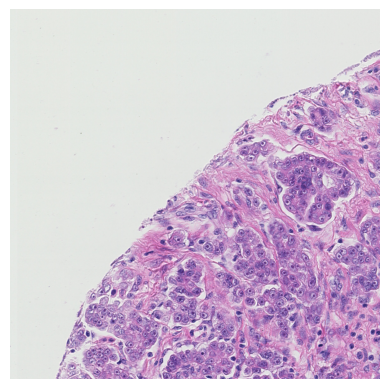

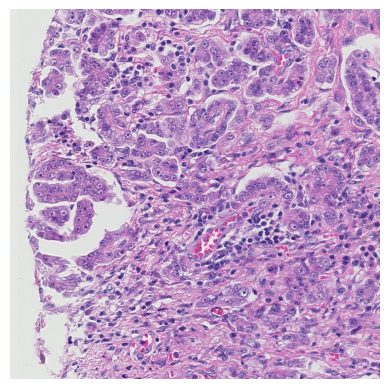

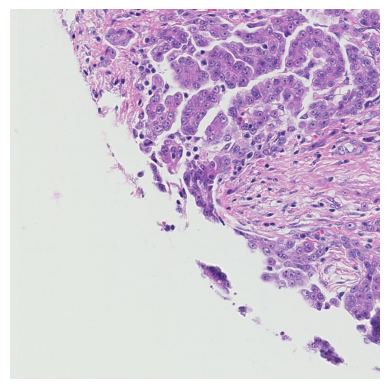

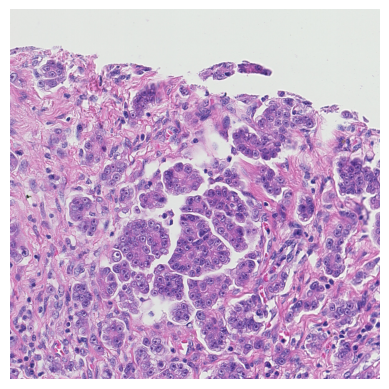

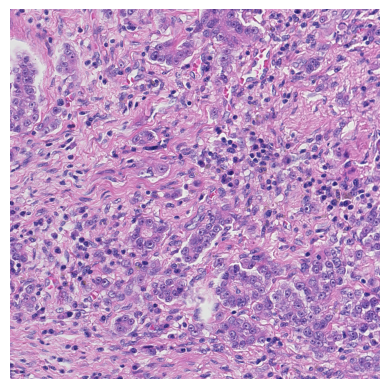

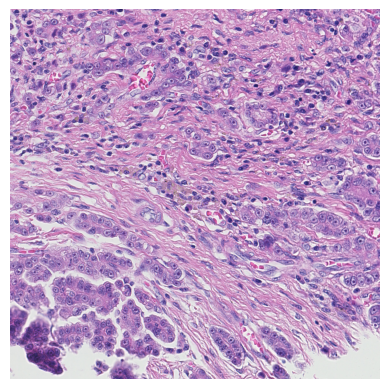

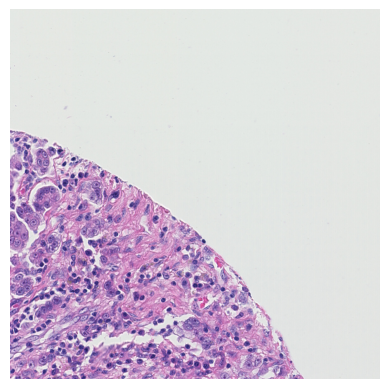

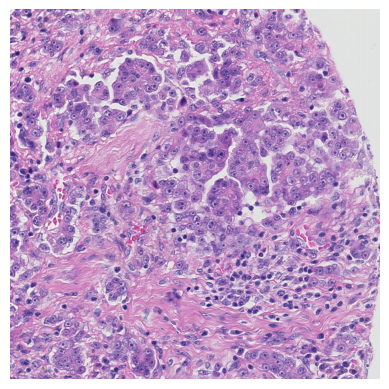

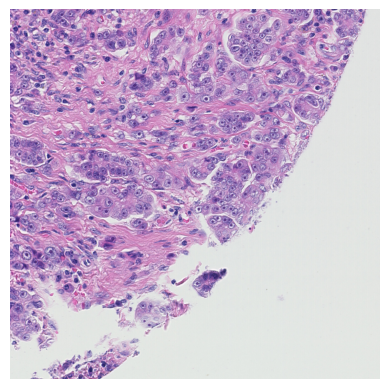

In [42]:
def has_numbers(inputString):
    if any(char.isdigit() for char in str(inputString)):
        num = inputString.split("MESO")[-1]
        try:
            num = int(num)
        except:
            return None
        return num
    else:
        return None
    

import pandas as pd
import warnings
warnings.filterwarnings("ignore")

########################################################################################################################
excel_file = "/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/MESO_TMA_Maps full.xlsx"
xls = pd.ExcelFile(excel_file)
meta_data_list = []
columns = ["Core Row","Core Column", "Case Number", "Specimen Number", "Donor Block", "Tissue Type"] 
for tma_map in xls.sheet_names:
    temp = pd.read_excel(xls, sheet_name=tma_map)[columns]
    temp['tma'] = [tma_map] * len(temp)
    meta_data_list.append(temp)
df = pd.concat(meta_data_list)

df['Case Number'] = df['Case Number'].astype(str)
df['Case Number'] = df['Case Number'].str.replace(" ", "")
df['Case Number'] = df['Case Number'].str.upper()
df['case_Id'] = df['Case Number'].apply(lambda x: has_numbers(x))
df = df.dropna(subset=['case_Id'])
df.rename(columns={"Core Row": "row", "Core Column": "col", "Case Number": "case", "Specimen Number": "specimen_number", "Donor Block": "donor_block", "Tissue Type": "type"}, inplace=True)

df['type'] = df['type'].str.capitalize()
df.replace("Sarcomasoid", "Sarcomatoid", inplace=True)
df['type'].replace("Desmoplastic sarcomatoid", "Desmoplastic", inplace=True)
df['type'].replace("No tumour sampled", "Healthy", inplace=True)
df['type'] = df['type'].str.replace(" ", "")

########################################################################################################################
df_patients = pd.read_csv("/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/files/Mesothelioma_patients_labels_full.csv")

# ['Sample_Identifier', 'case_Id', 'type', 'Stage', 'T_Stage', 'TNM_Stage', 'os_event_ind', 'os_event_data', 'smoking_history', 'wcc_score', 'desmoplastic_component', 'Meso_type', 'age', 'Sex', 'recurrence', 'time_to_recurrence', 'confident_diagnosis', 'HB_score' ]

col_pat = ['Case Number','Mesothelioma Type','Desmoplastic Component',  'Smoking History', 'T Stage', 'Overall Stage (8th Edition TNM)', 'Time to Survival Status (Months)', 'Survival Status', 'Hb score', 'WCC Score', 'Number of Cores', 'Follow-Up Status', 'Time to Follow-Up Status (Months)', 'TMA Array Number', 'Donor Block Number']

cm = ['Core Row', 'Core Column', 'Core Mesothelioma Type', 'ATP5A Cytoplasmic H-Score', 'ATP5A Positive Tumour Area (%)', 'eif4A1 Cytoplasmic H-Score', 'eif4A1 Positive Tumour Area (%)', 'eif4A2 Cytoplasmic H-Score', 'eif4A2 Positive Tumour Area (%)', 'p-S6 Cytoplasmic H-Score', 'p-S6 Positive Tumour Area (%)', 'SDHB Cytoplasmic H-Score', 'SDHB Positive Tumour Area (%)', 'ki67 Nuclear H-Score', 'ki67 Positive Tumour Area (%)', 'DDX3X Cytoplasmic H-Score', 'DDX3X Positive Tumour Area (%)']

cols = col_pat + cm + [x+'.1' for x in cm] + [x+'.2' for x in cm]  
df_patients = df_patients[cols]
new_cols = ['row', 'cols', 'core_type', 'ATP5A Cytoplasmic H-Score', 'ATP5A Positive Tumour Area (%)', 'eif4A1 Cytoplasmic H-Score', 'eif4A1 Positive Tumour Area (%)', 'eif4A2 Cytoplasmic H-Score', 'eif4A2 Positive Tumour Area (%)', 'p-S6 Cytoplasmic H-Score', 'p-S6 Positive Tumour Area (%)', 'SDHB Cytoplasmic H-Score', 'SDHB Positive Tumour Area (%)', 'ki67 Nuclear H-Score', 'ki67 Positive Tumour Area (%)', 'DDX3X Cytoplasmic H-Score', 'DDX3X Positive Tumour Area (%)']
core_list = []
for cols_itr in [cm , [x+'.1' for x in cm], [x+'.2' for x in cm]]:
    for row in df_patients[col_pat+ cols_itr ].iterrows():
        core_list.append(row[1].values)

core_df = pd.DataFrame(core_list, columns= col_pat+new_cols)
# reanme
core_df.rename(columns={'Case Number': 'case_Id', 'Mesothelioma Type':'type', 'Desmoplastic Component':'desmoplastic_component', 'Smoking History': 'smoking_history', 'T Stage':'T_Stage', 'Overall Stage (8th Edition TNM)': 'Stage', 'Time to Survival Status (Months)':'os_event_data', 'Survival Status':'os_event_ind', 'Hb score':'HB_score', 'WCC Score':'wcc_score', 'Number of Cores':'cores', 'Time to Follow-Up Status (Months)':'time_to_recurrence', 'Follow-Up Status':'recurrence' }, inplace=True)
########################################################################################################################



core_df['mkey'] = core_df['case_Id'].astype(float).astype(str) + '_' + core_df['row'].astype(str) + '_' + core_df['cols'].astype(str)
df['mkey'] = df['case_Id'].astype(str) + '_' + df['col'].astype(str) + '_' +df['row'].astype(float).astype(str) 

meta_final = pd.merge(df, core_df, how='left', on='mkey', suffixes=(None, '_extra')) #for no filter based on the IHC markers in the meso_patient file
# meta_final = pd.merge(df, core_df, how='inner', on='mkey', suffixes=(None, '_extra')) #for filtering based on the IHC experssions (8 old TMAs)
drop_cols = [x for x in meta_final.columns if x.endswith('_extra')] +['mkey']
meta_final.drop(drop_cols, axis=1, inplace=True)
meta_final['tma'] = meta_final['tma'].str.replace(' ','')


meta_final['tmakey'] = meta_final['tma'].str.upper() + '_' + meta_final['row'].astype(str) + '-' + meta_final['col'].astype(str)
meta_final

,row,col,case,specimen_number,donor_block,type,tma,case_Id,desmoplastic_component,smoking_history,...,eif4A2 Positive Tumour Area (%),p-S6 Cytoplasmic H-Score,p-S6 Positive Tumour Area (%),SDHB Cytoplasmic H-Score,SDHB Positive Tumour Area (%),ki67 Nuclear H-Score,ki67 Positive Tumour Area (%),DDX3X Cytoplasmic H-Score,DDX3X Positive Tumour Area (%),tmakey
0,5,A,\n(EM)MESO1,PR050223P/14,13.0,Epithelioid,Meso1,1.0,NaN,Ex-smoker,...,8.27,53.16,14.09,8.15,4.34,33.95,17.73,0.00,0.0,MESO1_5-A
1,6,A,\n(EM)MESO1,PR050223P/14,15.0,Epithelioid,Meso1,1.0,NaN,Ex-smoker,...,4.52,48.58,11.50,5.72,3.33,69.22,44.10,0.00,0.0,MESO1_6-A
2,7,A,\n(EM)MESO1,PR050223P/14,16.0,Epithelioid,Meso1,1.0,NaN,Ex-smoker,...,3.13,29.75,8.79,8.91,4.15,46.52,30.77,0.00,0.0,MESO1_7-A
3,9,A,\n(EM)MESO2,PR050313G/14,19.0,Epithelioid,Meso1,2.0,NaN,Never smoked,...,1.48,234.16,45.07,14.71,9.28,108.33,63.02,0.17,0.0,MESO1_9-A
4,10,A,\n(EM)MESO2,PR050313G/14,28.0,Epithelioid,Meso1,2.0,NaN,Never smoked,...,0.36,144.55,29.13,123.54,39.07,15.97,11.20,0.00,0.0,MESO1_10-A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1405,10,J,88,PR084250H/13,17,Epithelioid,Meso12,88.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MESO12_10-J
1406,11,J,88,PR084250H/13,18,Epithelioid,Meso12,88.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MESO12_11-J
1407,13,J,89,PR084323F/13,12,Epithelioid,Meso12,89.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MESO12_13-J
1408,14,J,89,PR084323F/13,15,Epithelioid,Meso12,89.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MESO12_14-J


In [43]:
import h5py

h5_file_read = "/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso_TMA/h224_w224_n3_zdim128/hdf5_Meso_TMA_he_complete.h5"
h5_file_write = "/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso_TMA/h224_w224_n3_zdim128/hdf5_Meso_TMA_he_complete_meta.h5"
matching_key = 'slides'

    
meta_lookup = {key: i for i, key in enumerate(meta_final['tmakey'])}

with h5py.File(h5_file_read, 'r') as f_read:
    keys = list(f_read.keys())
    with h5py.File(h5_file_write, 'w') as f_write:
        for key in keys:
            f_write.create_dataset(key, (0,) + f_read[key].shape[1:], 
                                  maxshape=(None,) + f_read[key].shape[1:],
                                  dtype=f_read[key].dtype, chunks=True)
        
        meta_columns = meta_final.columns.tolist()
        for col in meta_columns:
            if meta_final[col].dtype == 'object': 
                # For string
                dt = 'S30'
            else:
                # For numeric
                dt = 'uint8'
            
            f_write.create_dataset(f'{col}', (0,), maxshape=(None,), dtype=dt, chunks=True)
        
        # Iterate through the original dataset and add matching entries
        count = 0
        for i in range(len(f_read[matching_key])):
            # Get the identifier from the h5 file
            h5_id = f_read[matching_key][i]
            if not isinstance(h5_id, str):
                h5_id = h5_id.decode()
            
            # Check if this ID is in our metadata
            if h5_id in meta_lookup:
                # Get the corresponding metadata index
                meta_idx = meta_lookup[h5_id]
                
                # Add the data from the original file
                for key in keys:
                    current_len = f_write[key].shape[0]
                    f_write[key].resize((current_len + 1,) + f_write[key].shape[1:])
                    f_write[key][current_len] = f_read[key][i]
                
                # Add all metadata columns
                for col in meta_columns:
                    current_len = f_write[f'{col}'].shape[0]
                    f_write[f'{col}'].resize((current_len + 1,))
                    f_write[f'{col}'][current_len] = meta_final[col].iloc[meta_idx]
                
                count += 1
                
                if count % 1000 == 0:  # Print progress
                    print(f"Processed {count} matching entries")
        
        print(f"Total matching entries found and added: {count}")

Processed 1000 matching entries
Processed 2000 matching entries
Processed 3000 matching entries
Processed 4000 matching entries
Processed 5000 matching entries
Total matching entries found and added: 5207


In [44]:
# h5_file_read = "/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso_TMA/h224_w224_n3_zdim128/hdf5_Meso_TMA_he_complete.h5"
# h5_file_read = "/nfs/home/users/fshahi/Projects/Datasets/Meso_TMA/block2/he/patches_h224_w224/hdf5_Meso_TMA_he_train.h5"
h5_file_read = "/nfs/home/users/fshahi/Projects/Histomorphological-Phenotype-Learning/results/BarlowTwins_3/Meso_TMA/h224_w224_n3_zdim128/hdf5_Meso_TMA_he_complete_meta.h5"
# print the keys
import h5py
with h5py.File(h5_file_read, 'r') as f_read:
    keys = list(f_read.keys())
    dataset_length = len(f_read[keys[0]])
    print("Keys: %s" % keys)
    for key in keys:
        print(f_read[key])
        print(f_read[key].shape)
        print(f_read[key][0])
        print(f_read[key][-1])
        print(f_read[key][1000])
        
        print('-------------------------------------------------------------')


Keys: ['ATP5A Cytoplasmic H-Score', 'ATP5A Positive Tumour Area (%)', 'DDX3X Cytoplasmic H-Score', 'DDX3X Positive Tumour Area (%)', 'Donor Block Number', 'HB_score', 'SDHB Cytoplasmic H-Score', 'SDHB Positive Tumour Area (%)', 'Stage', 'TMA Array Number', 'T_Stage', 'case', 'case_Id', 'col', 'cols', 'core_type', 'cores', 'desmoplastic_component', 'donor_block', 'eif4A1 Cytoplasmic H-Score', 'eif4A1 Positive Tumour Area (%)', 'eif4A2 Cytoplasmic H-Score', 'eif4A2 Positive Tumour Area (%)', 'hist_subtype', 'img_h_latent', 'img_z_latent', 'indexes', 'ki67 Nuclear H-Score', 'ki67 Positive Tumour Area (%)', 'labels', 'original_set', 'os_event_data', 'os_event_ind', 'p-S6 Cytoplasmic H-Score', 'p-S6 Positive Tumour Area (%)', 'patterns', 'recurrence', 'row', 'samples', 'slides', 'smoking_history', 'specimen_number', 'tiles', 'time_to_recurrence', 'tma', 'tmakey', 'type', 'wcc_score']
<HDF5 dataset "ATP5A Cytoplasmic H-Score": shape (5207,), type "|u1">
(5207,)
0
198
235
--------------------